In [ ]:
import requests
from io import BytesIO
from PIL import Image
import torch
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import torch.nn as nn
from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler
import scipy.ndimage

In [2]:
response=requests.get('https://th.bing.com/th/id/OIP.5vYoG-ywA-DbjQ6nGMuKwQAAAA?rs=1&pid=ImgDetMain')
if response.status_code == 200:
  img = Image.open(BytesIO(response.content))

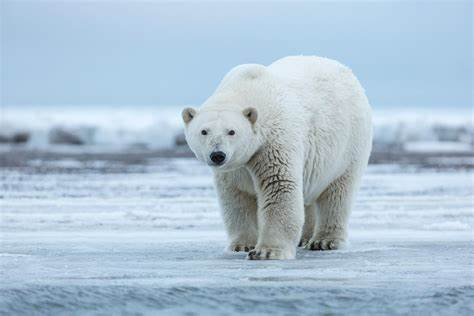

In [3]:
img

In [4]:
opencv_image = np.array(img)
opencv_image = cv2.cvtColor(opencv_image, cv2.COLOR_RGB2BGR)

In [5]:
r_channel,g_channel,b_channel = cv2.split(opencv_image)

In [6]:
def factorise(A,k,device=torch.device('cpu')):

  A.to(device)

  W = torch.randn(A.shape[0],k,requires_grad=True,device=device)
  H = torch.randn(k,A.shape[1],requires_grad=True,device=device)

  optimizer = torch.optim.Adam([W,H],lr=0.01)

  losses=[]
  flat_loss = 0
  threshold = 10
  prev_loss = float('-inf')

  iteration=0
  while True:

    loss = torch.mm(W,H)-A
    mask = ~torch.isnan(loss)

    loss = loss[mask]
    loss = torch.norm(loss)

    # print(f'Iteration number: {iteration+1}  Loss: {loss.detach().cpu()}')
    losses.append(loss.detach().cpu())
    if loss.detach().cpu()>=prev_loss:
      flat_loss+=1

    else:
      flat_loss=0

    if flat_loss >=threshold:
      break

    prev_loss=loss.detach().cpu()
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    iteration+=1

  return W,H,losses

In [7]:
blue_tensor = torch.tensor(b_channel,dtype=torch.float)/255
green_tensor = torch.tensor(g_channel,dtype=torch.float)/255
red_tensor = torch.tensor(r_channel,dtype=torch.float)/255

In [8]:
red_tensor=torchvision.transforms.functional.crop(red_tensor,50,150,250,250)
blue_tensor=torchvision.transforms.functional.crop(blue_tensor,50,150,250,250)
green_tensor=torchvision.transforms.functional.crop(green_tensor,50,150,250,250)


In [9]:
green_tensor.mean()

tensor(0.7433)

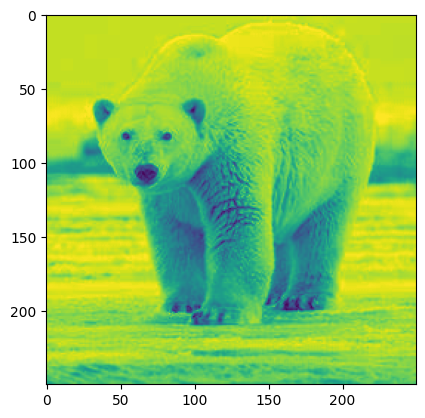

In [10]:
plt.imshow(red_tensor)

# Q1

### (i) Pick an image of your liking and reconstruct it using matrix factorization. Choose a suitable value for the rank. Run Gradient Descent until it converges

In [11]:
loss_r,loss_g,loss_b = [],[],[]

for r in list(range(20,100,10)):
  print(f'r={r}')
  Wr,Hr,losses_r=factorise(red_tensor,r)
  Wg,Hg,losses_g=factorise(green_tensor,r)
  Wb,Hb,losses_b=factorise(blue_tensor,r)

  loss_r.append(losses_r[-1])
  loss_g.append(losses_g[-1])
  loss_b.append(losses_b[-1])


r=20
r=30
r=40
r=50
r=60
r=70
r=80
r=90


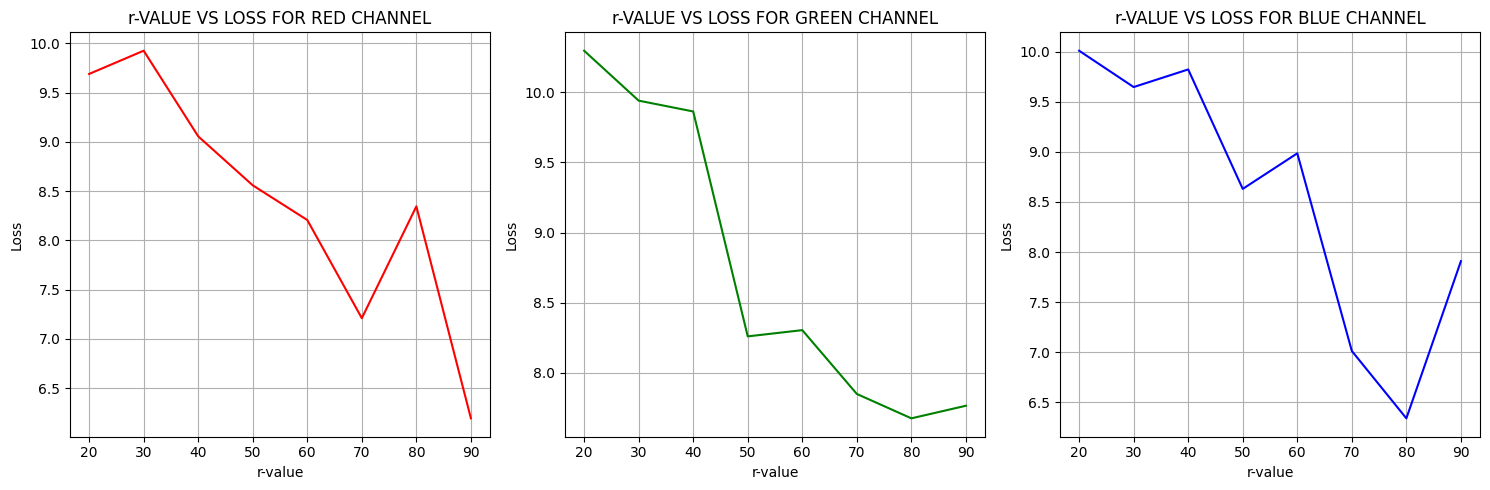

In [12]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.grid(True)
plt.plot(list(range(20,100,10)),loss_r,color='red')
plt.title('r-VALUE VS LOSS FOR RED CHANNEL')
plt.xlabel('r-value')
plt.ylabel('Loss')
plt.tight_layout()

plt.subplot(1,3,2)
plt.grid(True)
plt.plot(list(range(20,100,10)),loss_g,color='green')
plt.title('r-VALUE VS LOSS FOR GREEN CHANNEL')
plt.xlabel('r-value')
plt.ylabel('Loss')
plt.tight_layout()

plt.subplot(1,3,3)
plt.grid(True)
plt.plot(list(range(20,100,10)),loss_b,color='blue')
plt.title('r-VALUE VS LOSS FOR BLUE CHANNEL')
plt.xlabel('r-value')
plt.ylabel('Loss')
plt.tight_layout()

We have to choose a value of r which is neither too big, and nor the error corresponding to it is large enough.

In [13]:
Wr,Hr,losses_r=factorise(red_tensor,70)
Wg,Hg,losses_g=factorise(green_tensor,70)
Wb,Hb,losses_b=factorise(blue_tensor,70)


In [14]:
original_img = torch.stack([blue_tensor,green_tensor,red_tensor], dim=2)

r_reconstructed = torch.mm(Wr,Hr)
g_reconstructed = torch.mm(Wg,Hg)
b_reconstructed = torch.mm(Wb,Hb)

reconstructed_img = torch.stack([b_reconstructed,g_reconstructed,r_reconstructed],dim=2).detach().cpu()

In [15]:
original_img.shape

torch.Size([250, 250, 3])

### (ii)  plot the reconstructed image alongside the original image

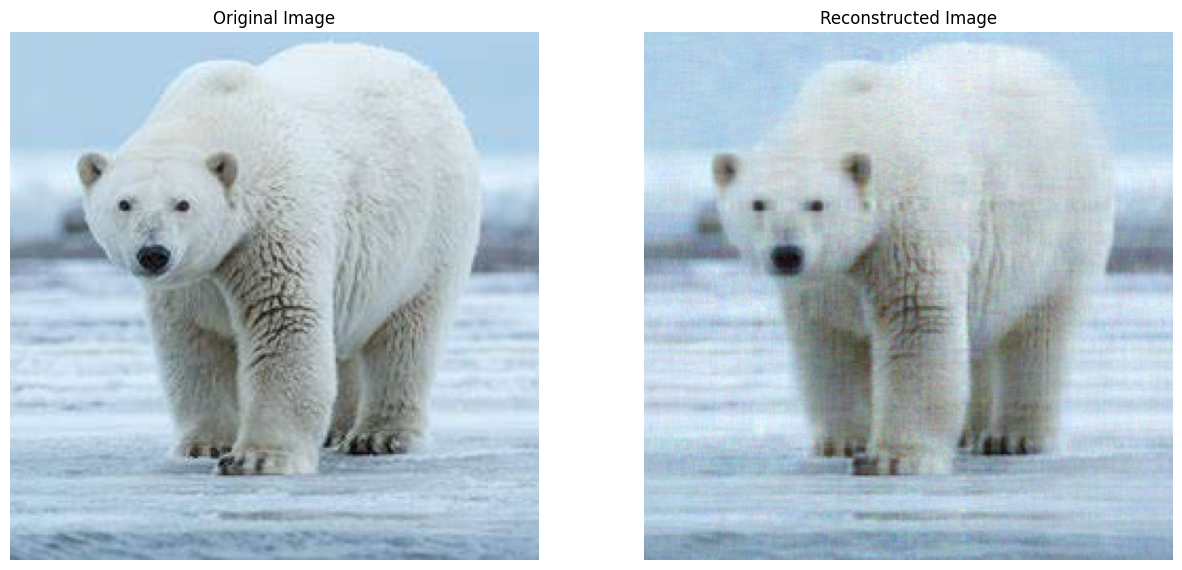

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(original_img)
plt.title('Original Image')

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(reconstructed_img)
plt.title('Reconstructed Image')

plt.show()

### (iii) Calculate and report the RMSE and PSNR metrics.

In [17]:
def rmse(pred, true):
    assert pred.shape == true.shape, "Shape mismatch between predicted and true images"

    mask = ~torch.isnan(pred) & ~torch.isnan(true)

    if not torch.any(mask):
        return float('nan')

    mse = torch.mean((pred[mask] - true[mask]) ** 2)
    rmse_value = torch.sqrt(mse)

    return rmse_value.item()


def psnr(pred, true, max_pixel_value=1.0):
    assert pred.shape == true.shape, "Shape mismatch between predicted and true images"

    mask = ~torch.isnan(pred) & ~torch.isnan(true)

    if not torch.any(mask):
        return float('nan')

    mse = torch.mean((pred[mask] - true[mask]) ** 2)

    if mse == 0:
        return float('inf')

    psnr_value = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr_value.item()


In [18]:
rmse_r = rmse(r_reconstructed,red_tensor)
rmse_g = rmse(g_reconstructed,green_tensor)
rmse_b = rmse(b_reconstructed,blue_tensor)

avg_rmse = (rmse_r + rmse_g + rmse_b)/3

print(f"RMSE Red Channel: {rmse_r}")
print(f"RMSE Green Channel: {rmse_g}")
print(f"RMSE Blue Channel: {rmse_b}")
print(f"Average RMSE: {avg_rmse}")

RMSE Red Channel: 0.03040754422545433
RMSE Green Channel: 0.03409109637141228
RMSE Blue Channel: 0.03716924414038658
Average RMSE: 0.03388929491241773


In [19]:
psnr_r = psnr(r_reconstructed,red_tensor)
psnr_g = psnr(g_reconstructed,green_tensor)
psnr_b = psnr(b_reconstructed,blue_tensor)

avg_psnr = (psnr_r+psnr_g+psnr_b)/3

print(f"PSNR Red Channel: {psnr_r} dB")
print(f"PSNR Green Channel: {psnr_g} dB")
print(f"PSNR Blue Channel: {psnr_b} dB")
print(f"Average PSNR: {avg_psnr} dB")


PSNR Red Channel: 30.340373992919922 dB
PSNR Green Channel: 29.34718132019043 dB
PSNR Blue Channel: 28.596324920654297 dB
Average PSNR: 29.42796007792155 dB


# Q2

### (i)Consider a case where 900 pixels (30x30) are randomly missing from an image.

In [20]:
def remove_random_pixels(tensor, num=900):

    mask = torch.ones(tensor.shape, dtype=torch.bool)
    total_pixels = tensor.shape[0] * tensor.shape[1]

    indices_to_remove = np.random.choice(total_pixels, num, replace=False)

    flat_mask = mask.view(-1)
    flat_mask[indices_to_remove] = False

    masked_tensor = tensor.clone()
    masked_tensor.view(-1)[~flat_mask] = float('nan')

    return masked_tensor


In [21]:
masked_red = remove_random_pixels(red_tensor)
masked_green = remove_random_pixels(green_tensor)
masked_blue = remove_random_pixels(blue_tensor)

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


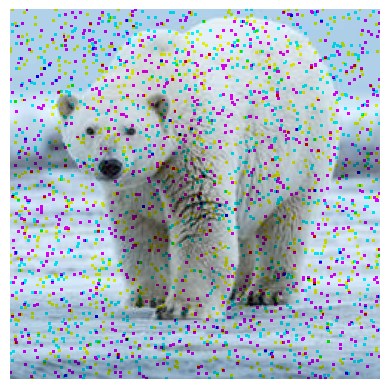

In [22]:
masked_img = torch.stack([masked_blue,masked_green,masked_red],dim=2).detach().cpu()
plt.axis('off')
plt.imshow(masked_img)

### (ii) Reconstruct the image using matrix factorization, plot the reconstructed image

In [23]:
Wr,Hr,losses_r=factorise(masked_red,70)
Wg,Hg,losses_g=factorise(masked_green,70)
Wb,Hb,losses_b=factorise(masked_blue,70)

r_reconstructed = torch.mm(Wr,Hr)
g_reconstructed = torch.mm(Wg,Hg)
b_reconstructed = torch.mm(Wb,Hb)

reconstructed_img = torch.stack([b_reconstructed,g_reconstructed,r_reconstructed],dim=2).detach().cpu()

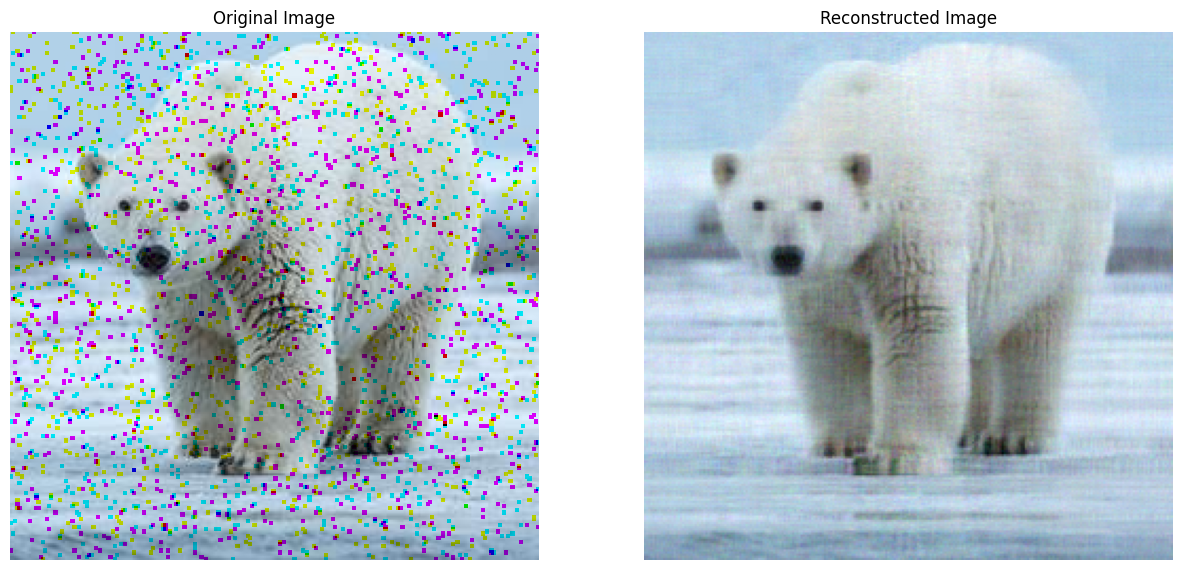

In [24]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(masked_img)
plt.title('Original Image')

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(reconstructed_img)
plt.title('Reconstructed Image')

plt.show()

### (iii) calculate the RMSE and PSNR metrics

In [25]:
rmse_r = rmse(r_reconstructed,masked_red)
rmse_g = rmse(g_reconstructed,masked_green)
rmse_b = rmse(b_reconstructed,masked_blue)

avg_rmse = (rmse_r + rmse_g + rmse_b)/3

print(f"RMSE Red Channel: {rmse_r}")
print(f"RMSE Green Channel: {rmse_g}")
print(f"RMSE Blue Channel: {rmse_b}")
print(f"Average RMSE: {avg_rmse}")

RMSE Red Channel: 0.03363492339849472
RMSE Green Channel: 0.03501008823513985
RMSE Blue Channel: 0.03375106677412987
Average RMSE: 0.03413202613592148


In [26]:
psnr_r = psnr(r_reconstructed,masked_red)
psnr_g = psnr(g_reconstructed,masked_green)
psnr_b = psnr(b_reconstructed,masked_blue)

avg_psnr = (psnr_r+psnr_g+psnr_b)/3

print(f"PSNR Red Channel: {psnr_r} dB")
print(f"PSNR Green Channel: {psnr_g} dB")
print(f"PSNR Blue Channel: {psnr_b} dB")
print(f"Average PSNR: {avg_psnr} dB")

PSNR Red Channel: 29.464189529418945 dB
PSNR Green Channel: 29.11613655090332 dB
PSNR Blue Channel: 29.434249877929688 dB
Average PSNR: 29.338191986083984 dB


### (iv) Reconstruct the same image with the missing pixels using Random Fourier Features (RFF) and Linear Regression

In [27]:


def create_coordinate_map(img):
    height, width, num_channels = img.shape

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float()
    Y = torch.tensor(img.reshape(-1, num_channels), dtype=torch.float)

    return X, Y

def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    criterion = nn.MSELoss(reduction='mean')  # Default to mean reduction
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        # Calculate loss, ignoring NaN values
        mask = torch.isnan(Y).any(dim=1)
        loss = criterion(outputs[~mask], Y[~mask]) if mask.any() else torch.tensor(0.0)

        loss.backward()
        optimizer.step()

        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

X, Y = create_coordinate_map(masked_img)

scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X)
X_scaled = torch.tensor(scaler_X.transform(X), dtype=torch.float)

X_rff = create_rff_features(X_scaled, 15000, 0.008)
lin_model = LinearModel(X_rff.shape[1], 3)

train(lin_model, 0.005, X_rff, Y, 2500)


<ipython-input-27-6d02782160c4>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(img.reshape(-1, num_channels), dtype=torch.float)


Epoch 0 loss: 0.562177
Epoch 100 loss: 0.098590
Epoch 200 loss: 0.016173
Epoch 300 loss: 0.007715
Epoch 400 loss: 0.006018
Epoch 500 loss: 0.004987
Epoch 600 loss: 0.004219
Epoch 700 loss: 0.003627
Epoch 800 loss: 0.003164
Epoch 900 loss: 0.002797
Epoch 1000 loss: 0.002503
Epoch 1100 loss: 0.002264
Epoch 1200 loss: 0.002066
Epoch 1300 loss: 0.001898
Epoch 1400 loss: 0.001753


KeyboardInterrupt: 

In [28]:
height, width, num_channels = masked_img.shape
lin_model.eval()
with torch.no_grad():
    outputs = lin_model(X_rff)
    outputs = outputs.reshape(height, width, num_channels)

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


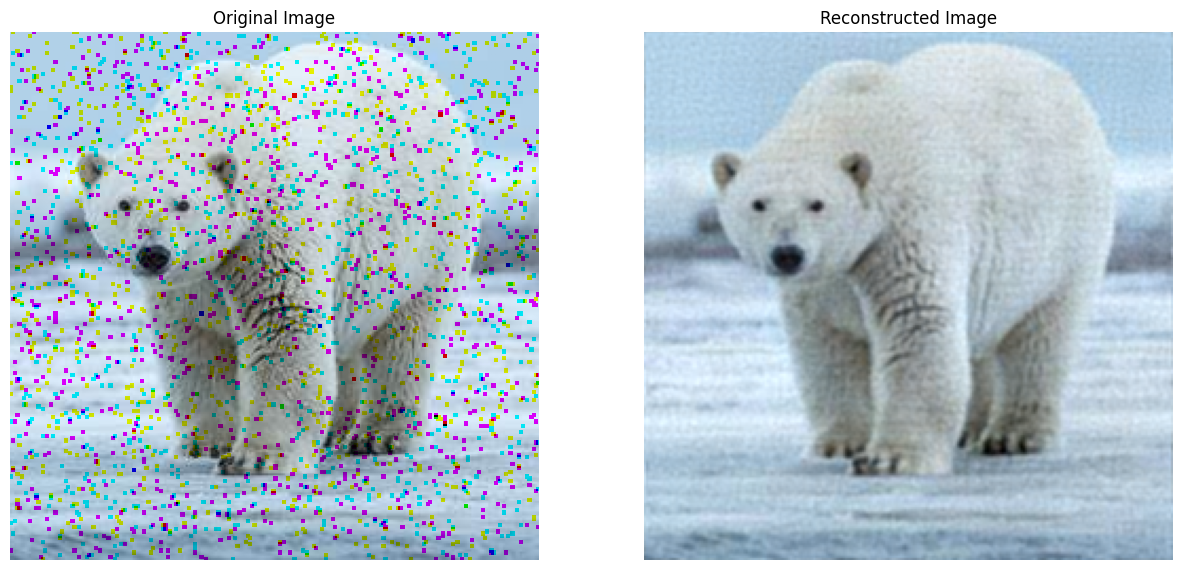

In [29]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(masked_img)
plt.title('Original Image')

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(outputs)
plt.title('Reconstructed Image')

plt.show()